# Info

**Project**

Assessment of gap-filling techniques applied to satellite phytoplankton composition products for the Atlantic Ocean

**Credit**

**© Ehsan Mehdipour**, 2025. (ehsan.mehdipour@awi.de)

Alfred Wegener Insitute for Polar and Marine Research, Bremerhaven, Germany

This work is licensed under the **GNU General Public License v3.0 (GPL-3.0)**.  

**Objective**

This code is provided for preprocessing and formating the PFT and TChla dataset for inputing to the gap-filling models.

**Dataset**

The dataset is accessable through Copernicus Marine Service with the following DOI:
https://doi.org/10.48670/moi-00280 and Dataset ID: cmems_obs-oc_glo_bgc-plankton_my_l3-multi-4km_P1D

# Setup and configuration

## Import modules

In [1]:
# Modules for data analysis
import os
os.environ["OMP_NUM_THREADS"] = "1"
import xarray as xr
import numpy as np
import pandas as pd
import dask

# Modules for data visualisation
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib import gridspec
plt.rcParams['text.usetex'] = True

# Miscellaneous modules
from tqdm import tqdm

# Manual modules or parameters
from function import *
from params import *

## Dask setup for heavy computation and parallalization

In [2]:
## Creating SLURM Cluster
# cluster, client = dask_slurm_cluster(queue='smp', cores=16, scale=16)

## Creating Distributed Cluster
# client = dask_distributed_client(n_workers=8, threads_per_worker=None)

## Close the cluster after computation completed
# cluster.close()
# client.close()

## Input and output parameters configuration

In [3]:
# CSV file detailing the boundries of regions of interest (ROI)

regions = pd.read_csv('data/regions.csv', index_col=0)

In [ ]:
# Reading the metadata files for all satellite images in the data_dir folder

ds_read = xr.open_mfdataset(os.path.join(params['data_dir'],'*'), chunks='auto')
ds_read

# Extracting region of interest (ROI)

## Functions

In [ ]:
def extract_region(ds_read, regions, idx, params=params):
    ''' 
    This function will extract the region and time of interest from a large dataset.
    
    Parameters:
    ds_read (xr.Dataset): Initial read dataset containing all location and time
    regions (pd.dataframe): Dataframe showing the regions boundries
    idx (int): Index of the region of interest in the regions dataframe
    params (dict): Dictionary of parameters
    
    Returns:
    ds (xr.Dataset): Crop dataset to the specific regions location and interested time
    ds_unc_rel (xr.Dataset): Crop uncertainty dataset to the specific regions location and interested time
    flags (xr.Dataset): Crop flag dataset to the specific regions location showing valid pixels (i.e. sea and land)
    '''
    
    ds = ds_read.where(
        (ds_read.lat > regions.loc[idx].lat_min)&
        (ds_read.lon > regions.loc[idx].lon_min)&
        (ds_read.lat < regions.loc[idx].lat_max)&
        (ds_read.lon < regions.loc[idx].lon_max),
        drop=True
    ).sel(time=slice(params['start_date'],params['end_date']))
    
    flags = ds[params['flags']]
    ds_unc_rel= ds[params['UNC']]
    ds = ds[params['PFT']]
    
    return ds, ds_unc_rel, flags

In [ ]:
def read_sst(ds, params=params):
    '''
    This function read the sea surface temperature dataset, 
    normalize the dataset and interpolate the values to the PFT dataset locations
    
    Parameters:
    ds (xr.Dataset): PFT dataset of the regions of interest
    params (dict): Dictionary of parameters. Location of the sst file is saved as the 'sst_file'
    
    Returns:
    sst_norm_interp (xr.Dataset): Crop and interpolated SST dataset to the specific regions location and interested time
    sst_unc_interp (xr.Dataset): Crop and interpolated SST uncertainty dataset to the specific regions location and interested time
    
    '''
    ## Reading the SST dataset
    sst = xr.open_dataset(params['sst_file']).compute()
    sst = sst.rename({'latitude':'lat','longitude':'lon'})
    
    ## Normaliztion of SST dataset
    sst_mean = sst.analysed_sst.mean()
    sst_std = sst.analysed_sst.std(ddof = 1)
    sst_norm = (sst.analysed_sst - sst_mean) / sst_std
    sst_unc = sst.analysis_error / sst_std
    
    ## Interpolation of the SST dataset to the PFT pixel locations
    sst_norm_interp = sst_norm.interp_like(ds.CHL, method = 'nearest').astype('float32')
    sst_unc_interp = sst_unc.interp_like(ds.CHL, method = 'nearest').astype('float32')
    
    return sst_norm_interp, sst_unc_interp

In [ ]:
def extract_all_region(ds_read, regions_list, regions, params=params):
    ''' 
    This function will extract the ALL the region and time of interest from a large dataset.
    
    Parameters:
    ds_read (xr.Dataset): Initial read dataset containing all location and time
    regions_list (list): Indexes of the regions of interest in the regions dataframe to consider for extraction
    regions (pd.dataframe): Dataframe showing the regions boundries
    params (dict): Dictionary of parameters
    
    Returns:
    None
    The PFT and uncertainty dataset and/or merged of these products will be save to the locaiton of the 'out_dir'. 
    '''
    
    # creating a loop that iterate over all regions, extract the data and save them separately
    for idx in tqdm(regions_list):
        ds, ds_unc_rel, flags = extract_region(ds_read, regions, idx, params)

        ## PFT convert to the logarithmic scale
        ds = np.log10(ds)

        ## UNC_SD
        ds_unc_sd = unc_transform(ds_unc_rel)
        
        ## Adding SST
        sst_norm_interp, sst_unc_interp = read_sst(ds, params)
        
        ds['sst'] = sst_norm_interp
        ds_unc_sd['sst_uncertainty'] = sst_unc_interp
        
        ## Mask (combining the mask of PFT and SST)
        mask = xr.where(
            (flags.isel(time = 0) == 1) &
            (np.isnan(sst_norm_interp.isel(time = 0)))
            , 0, 1)
        ## Apply the mask to all data
        ds = ds.where(mask == 1)
        ds_unc_sd = ds_unc_sd.where(mask == 1)
        ds_unc_rel = ds_unc_rel.where(mask == 1)
        
        ## Add the mask to the dataset
        ds['mask'] = mask
        ds_unc_rel['mask'] = mask
        ds_unc_sd['mask'] = mask
        
        ## Save
        # ds.to_netcdf(os.path.join(params['output_dir'],str(idx),'ds.nc'))
        # ds_unc_rel.to_netcdf(os.path.join(params['output_dir'],str(idx),'ds_unc_rel.nc'))
        # ds_unc_sd.to_netcdf(os.path.join(params['output_dir'],str(idx),'ds_unc_sd.nc'))
        
        # ds_merged = xr.merge([ds, ds_unc_sd])
        # ds_merged.to_netcdf(os.path.join(params['output_dir'], str(idx),'ds_pft.nc'))

## Call

In [ ]:
extract_all_region(
    ds_read, list(regions.index), regions , params=params,
)

# Data partitioning
Splitting the dataset to train, validation and test batches

In [4]:
def remove_missing_dates(perc, ds, params=params):
    ''' 
    This function remove the timestamps in xr.Dataset with less 
    than e.g. 2% data availability for more accurate reconstruction.
    Consider that the importance of all PFTs and TChla are considered the same.
    
    Parameters:
    perc (int or float): lowest valid data availability
    ds (xr.Dataset): Region's dataset containing all timestamps
    params (dict): Dictionary of parameters
    
    Returns:
    ds_valid (xr.Dataset): Dataset with valid timestamps 
    '''
    
    ## Remove dates with less than 2% data
    
    ## Select dataset
    ds_pft = ds[params['PFT']]
    n_pft = len(params['PFT'])
    
    ## Computing the percentage of data availability considering PFTs and TChla
    ## data_avail_perc = (number of available pixels in all datasets) / (number of total valid pixel [e.g. all sea points])
    
    data_avail_perc = np.isfinite(ds_pft.to_array('pft')).sum(dim=['lon','lat','pft']) / (ds.mask.sum().values * n_pft) * 100
    valid_dates = data_avail_perc > perc # remove less and 2% data
    
    ## Keep expedition dates
    ## To ensure that we are reconstructing all the dates during the expedition
    expedition_time_mask = (valid_dates.time >= params['expedition_start_date']) & (valid_dates.time <= params['expedition_end_date'])
    valid_dates[expedition_time_mask] = True
    ds_valid = ds.sel(time=valid_dates)
    return ds_valid

In [5]:
def NaN_fill(ds, fill_value=-999):
    ''' 
    This function fill in the NaN values for feeding to DINEOF algorithm.
    As DINEOF do not accept dataset with NaN values.
    The _Fillvalue attribute is added to the dataset to be reconginzed by the DINEOF.
    
    Parameters:
    ds (xr.Dataset): Region's PFT dataset
    fill_value (int): value to be consider as the fill_value 
        (it is better to be a value not in the range of the PFT Chla Concentrations)
    
    Returns:
    ds_filled (xr.Dataset): Dataset with filled NaN values and _FillValue attribute for all its dataarrays. 
    '''
    
    ## Filling the xarray dataset for feeding to DINEOF
    
    ## Creating new dataset
    ds_filled = xr.Dataset()

    ## Iterating through dataset to fill the NaNs and setting the attribute
    for i in list(ds.data_vars):
        ds_filled[i] = ds[i].fillna(fill_value)
        ds_filled[i].attrs['_FillValue'] = fill_value
    
    ## Adding the mask layer
    ds_filled['mask'] = ds.mask

    return ds_filled

In [6]:
## Plot all the days with artficial clouds

def cloud_plot(idx, ds, ds_addcloud, cloud_mask, clouded_time, dataset_extension, params=params):

    for t in tqdm(range(len(cloud_mask.time))):
        
        # Create a figure and a gridspec
        fig = plt.figure(figsize=(17, 8), tight_layout=True)
        gs = gridspec.GridSpec(2, 3)
        fig.suptitle(f'Observation and added cloud - Area {str(idx)}')

        # Create subplots
        ax=[]
        ax.append(fig.add_subplot(gs[0, 0]))
        ax.append(fig.add_subplot(gs[:2,1]))
        ax.append(fig.add_subplot(gs[0, 2]))
        ax.append(fig.add_subplot(gs[1, 0]))
        ax.append(fig.add_subplot(gs[1, 2]))


        #Dates
        data_date = ds.DIATO.sel(time=clouded_time).isel(time=t).time.values.astype('datetime64[D]')
        cloud_date = cloud_mask.isel(time=t).time.values.astype('datetime64[D]')

        ## DIATO
        vmin = 10**ds.DIATO.sel(time=clouded_time).quantile(0.01).values
        vmax = 10**ds.DIATO.sel(time=clouded_time).quantile(0.99).values
        
        diato_label = params['plot_labels'][
            (params['plot_labels']>vmin)&
            (params['plot_labels']<vmax)
        ]

        (10**ds.DIATO.sel(time=clouded_time).isel(time=t)).plot(
            ax=ax[0], norm=LogNorm(vmin=vmin, vmax=vmax), cmap='viridis'
        )
        
        cloud_mask.isel(time=t).plot(ax=ax[1], cmap='Blues_r', add_colorbar=False)
        
        (10**ds_addcloud.DIATO.sel(time=clouded_time).isel(time=t)).plot(
            ax=ax[2], norm=LogNorm(vmin=diato_label[0], vmax=diato_label[-1]),cmap='viridis'
        )

        ax[0].set_aspect('equal')
        ax[1].set_aspect('equal')
        ax[2].set_aspect('equal')
        ax[3].set_aspect('equal')
        ax[4].set_aspect('equal')

        ax[0].set_title(f'Diatom Obs. [{data_date}]')
        ax[1].set_title(f'Cloud mask with modification derived from [{cloud_date}]')
        ax[2].set_title(f'Diatom Obs. + cloud [{cloud_date}]')

        ## CHL
        vmin = 10**ds.CHL.sel(time=clouded_time).quantile(0.02).values
        vmax = 10**ds.CHL.sel(time=clouded_time).quantile(0.98).values
        
        chl_label = params['plot_labels'][
            (params['plot_labels']>vmin)&
            (params['plot_labels']<vmax)
        ]

        (10**ds.CHL.sel(time=clouded_time).isel(time=t)).plot(ax=ax[3],norm=LogNorm(vmin=vmin, vmax=vmax),cmap='viridis')
        (10**ds_addcloud.CHL.sel(time=clouded_time).isel(time=t)).plot(ax=ax[4],norm=LogNorm(vmin=chl_label[0], vmax=chl_label[-1]),cmap='viridis')

        ax[3].set_title(f'TChla Obs. [{data_date}]')
        ax[4].set_title(f'TChla Obs. + cloud [{cloud_date}]')

        # plt.savefig(f'fig/regions/{str(idx)}/{dataset_extension}_addedcloud_{data_date}.jpg',dpi=600, bbox_inches='tight')
        # plt.close()

In [7]:
def Addcloud_monthly(
    ds,
    params=params,
    cv_number_monthly=1,
    threshold = 10,
    keep_expedition_dates = True,
):
    
    ''' 
    This function extract the cloud mask from a heavily cloudy date and apply the mask on a low 
    cloudy dates to create artificial cloud and use the masked data from validation purposes.
    
    Parameters:
    ds (xr.Dataset): input dataset
    params (dict): dictionary of parameters
    cv_number_monthly (int): number of cloud extraction per month along several years (e.g. January across several years) 
        to ensure the temporal distribution of masked data along the months
    threshold (int or float): the lower threshold in data availability (in percentile) NOT to acquire the cloud from.
    keep_expedition_dates (boolean): to make sure that we are not covering the dates during the expedition.
    
    Returns:
    None
    The dataset will be directly saved in the storage in the output_dir.
    '''
    
    ## Create lists
    # times
    cloud_time = []
    clouded_time = []
    # masks
    cloud_mask_lowest = []
    cloud_mask = []
    cloud_mask_chl = []
    
    ## Create the dataset for adding the cloud
    ds_addcloud = ds.copy(deep=True)
    ds_addcloud = ds_addcloud.drop('mask')
    
    ## Compute layer of any_missing (to check if any of the several DataArrays are missing in each time and location)
    any_missing = np.isnan(ds[params['PFT']]).to_array(dim='var').any(dim='var')
    
    ## Looping through the months to extract and apply the cloud mask
    for i in range(1,13):
        
        ## Separate monthly dates in several years
        monthly_dates = (~any_missing).where(ds.time.dt.month==i, drop=True)
        
        ## Compute the missing rate for each date and do not consider the dates with less than 5% data availability
        monthly_percent = monthly_dates.sum(dim=['lon','lat']) / ds.mask.sum().values * 100
        monthly_percent = monthly_percent.where(monthly_percent > 5, drop=True) # mask for less than 5% data
        
        ## Remove the dates with less than 5% date availability + 
        ## Remove the dates with less than threshold (e.g. 10%) percentile lowest data availability 
        ##      to remove the dates with high missing values due to satellite track
        monthly_percent_5p = monthly_percent[monthly_percent > np.nanpercentile(monthly_percent,threshold)]

        ## choose the date with the lowest data availability after considering all the conditions
        monthly_lowest_time = (monthly_percent_5p.sortby(monthly_percent_5p)[:cv_number_monthly]).time.values
        ## Save the date of the cloud mask
        cloud_time.append(monthly_lowest_time)
    
        ## Ensure not to remove the data from the expedition duration
        if keep_expedition_dates==True:
            monthly_percent = monthly_percent.where(
                (monthly_percent.time<params['expedition_start_date'] - params['delta']) | 
                (monthly_percent.time>params['expedition_end_date']   + params['delta']) ,
                drop=True,
            )

            
        ## Clouded dates: find the date with the highest data availability
        # monthly_percent_95p = monthly_percent[monthly_percent < np.nanpercentile(monthly_percent,100-threshold)]
        monthly_percent_95p = monthly_percent[monthly_percent < np.nanpercentile(monthly_percent,100-0)]
        monthly_highest_time = (monthly_percent_95p.sortby(monthly_percent_95p)[-cv_number_monthly:]).time.values
        # Save the date that the cloud mask would apply
        clouded_time.append(monthly_highest_time)
        
        ## Creating the cloud mask 
        mask = any_missing.sel(time=monthly_lowest_time) ## mask the places that any of the data is missing
        mask_chl = np.isnan(ds.CHL.sel(time=monthly_lowest_time)) ## Separate mask layer for TChla as it has more dataset. Not used!
        
        ##!!! We only consider the places that is missing in all the datasets by creating a base layer that all the data are present!!!
        base = (~any_missing).sel(time=monthly_highest_time) ## consider Base if all the data present.
        monthly_mask = mask & base.values
        monthly_mask_chl = mask_chl & base.values

        ## Append the mask to a list
        cloud_mask_lowest.append(mask)
        cloud_mask.append(monthly_mask)
        cloud_mask_chl.append(monthly_mask_chl) ## Not used

        
        ## Add cloud
        ds_addcloud.loc[{'time':monthly_highest_time}] = ds_addcloud.sel(time=monthly_highest_time).where(~monthly_mask.values)
        
    ## Create the list of dates with cloud mask or dates that the cloud is applied.
    cloud_time = np.concatenate(cloud_time)
    clouded_time = np.concatenate(clouded_time)

    ## Create dataset with the cloud mask itself
    cloud_mask = xr.concat(cloud_mask, dim='time')
    cloud_mask_chl = xr.concat(cloud_mask_chl, dim='time') ## Not used
    cloud_mask_lowest = xr.concat(cloud_mask_lowest, dim='time')
    
    ## Attaching the mask layer to the dataset
    ds_addcloud['mask'] = ds.mask 
    cloud_mask['sea_mask'] = ds.mask
    
    ## !!!CLOUD INDEX!!!
    ## Creating Cloud Index for the DINEOF reconstruction
    ## Basically we have to stack the dataset together and choose the index in the columns stack to mask.
    ## This should happen in a way that all the dataset in each timesteps are stack in one dimension vector data.
    
    # cloud_mask_stack = cloud_mask.stack(point=['lon','lat'])
    # cloud_mask_stack = cloud_mask_stack.where(cloud_mask_stack.sea_mask==1, drop=True)
    
    ## Creating a mask in the same number of data as the main dataset.
    cloud_mask_pfts = xr.concat([cloud_mask]*len(params['PFT']), dim='pft') # extend the cloud_mask to the number of pfts
    
    ## Stacking the dataset in a vector format
    cloud_mask_stack = cloud_mask_pfts.stack(points=['pft','lon','lat'])
    cloud_mask_stack = cloud_mask_stack.where(cloud_mask_stack.sea_mask==1, drop=True)
    
    ## saving the image number (cloud dates) and the pixel to be masked.
    img_num = []
    pixel_num = []
    for t_idx, t in enumerate(cloud_mask_stack.time.values):
        pixel_num_time = np.argwhere(cloud_mask_stack.sel(time=t).values).squeeze()
        pixel_num.append(pixel_num_time + 1)

        img_num_time = [(ds.time==clouded_time[t_idx]).argmax(dim='time').values+1] * len(pixel_num_time)
        img_num.append(img_num_time)

    ## Concatenate all
    pixel_num = np.concatenate(pixel_num)
    img_num = np.concatenate(img_num)
    
    ## Creating a dataset and netcdf of cloud_index
    ds_cloudindex = xr.Dataset()
    ds_cloudindex['clouds_index'] = xr.DataArray(data=np.vstack([pixel_num, img_num]),dims=['index','nbpoints'])
    
    return ds_addcloud, cloud_time, clouded_time , cloud_mask, cloud_mask_chl, ds_cloudindex

## Call

Region 1
number of dates region 1: 1051


/albedo/home/emehdipo/.conda/envs/olci_pft/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1555: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/albedo/home/emehdipo/.conda/envs/olci_pft/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1555: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/albedo/home/emehdipo/.conda/envs/olci_pft/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1555: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/albedo/home/emehdipo/.conda/envs/olci_pft/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1555: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
100%|████████████████████████████████████████████████████████████████████████████████████████████████| 11/11 [00:09<00:00,  1.14it/s]


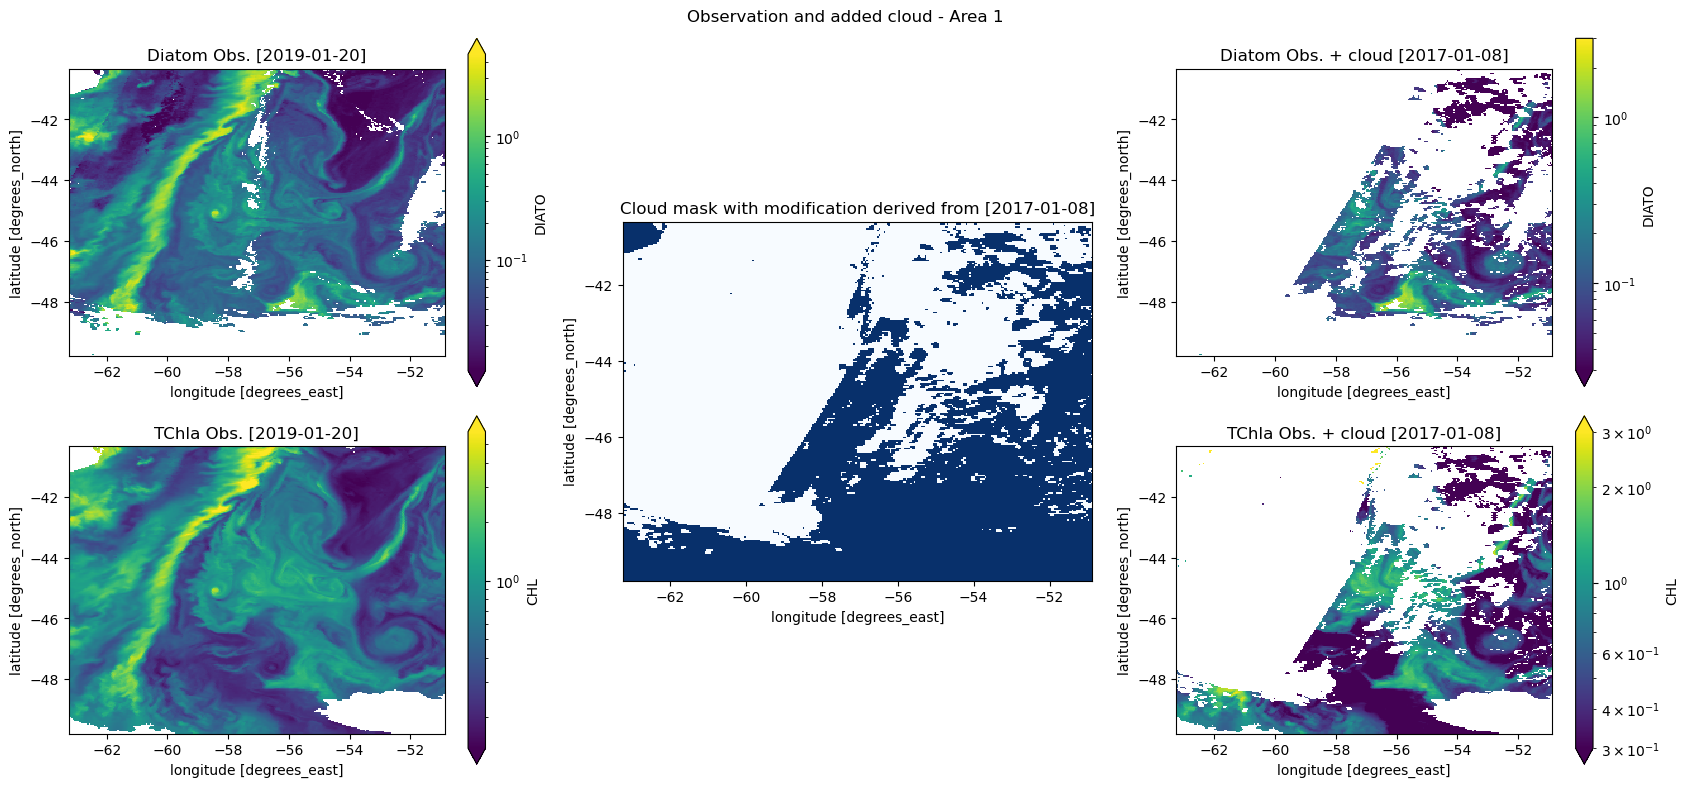

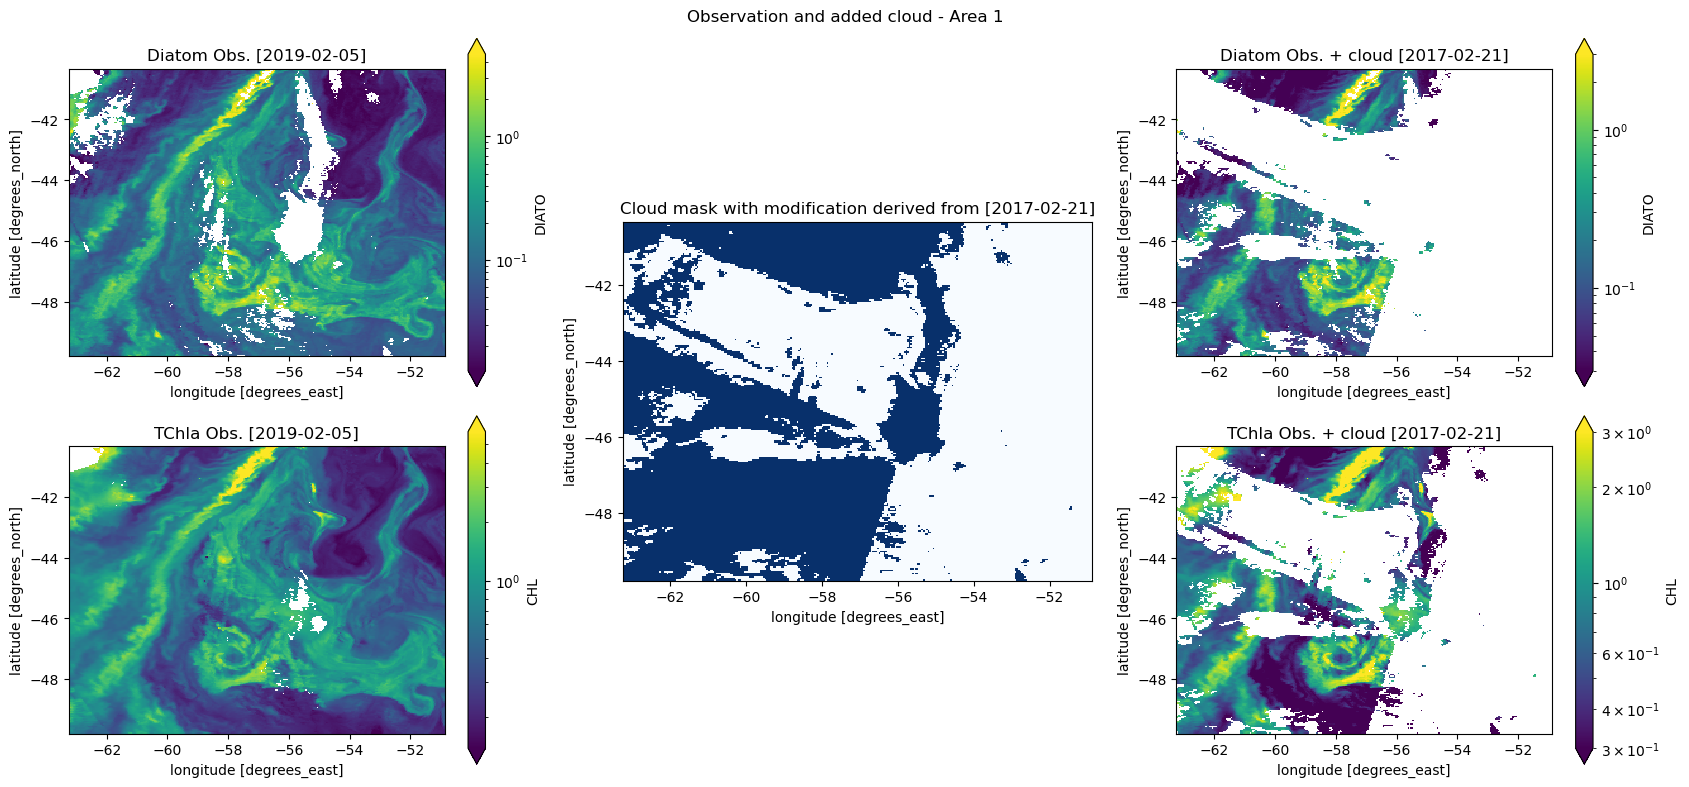

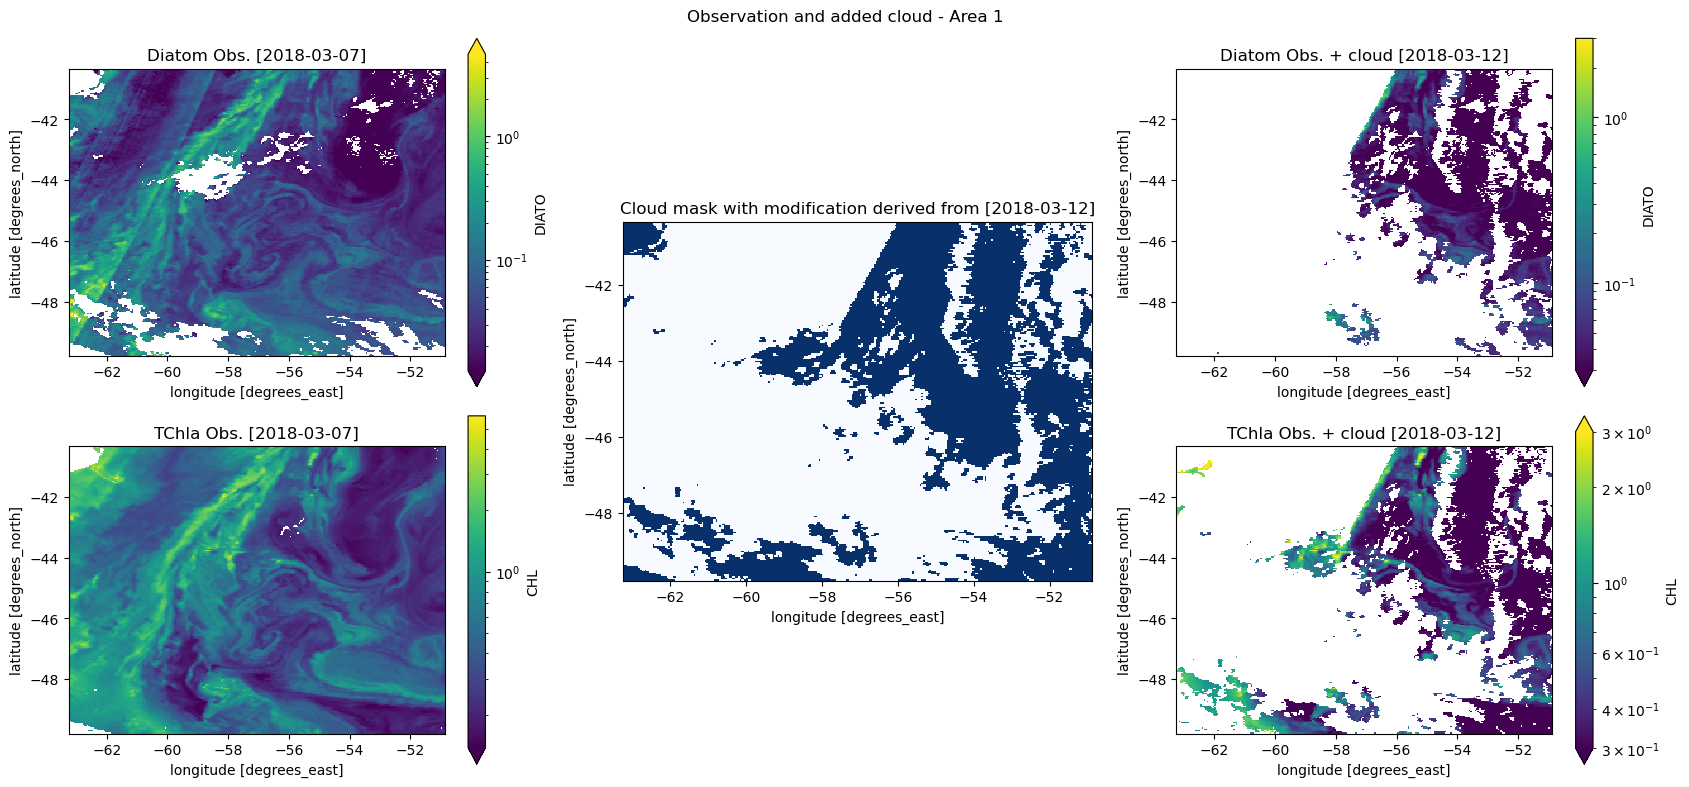

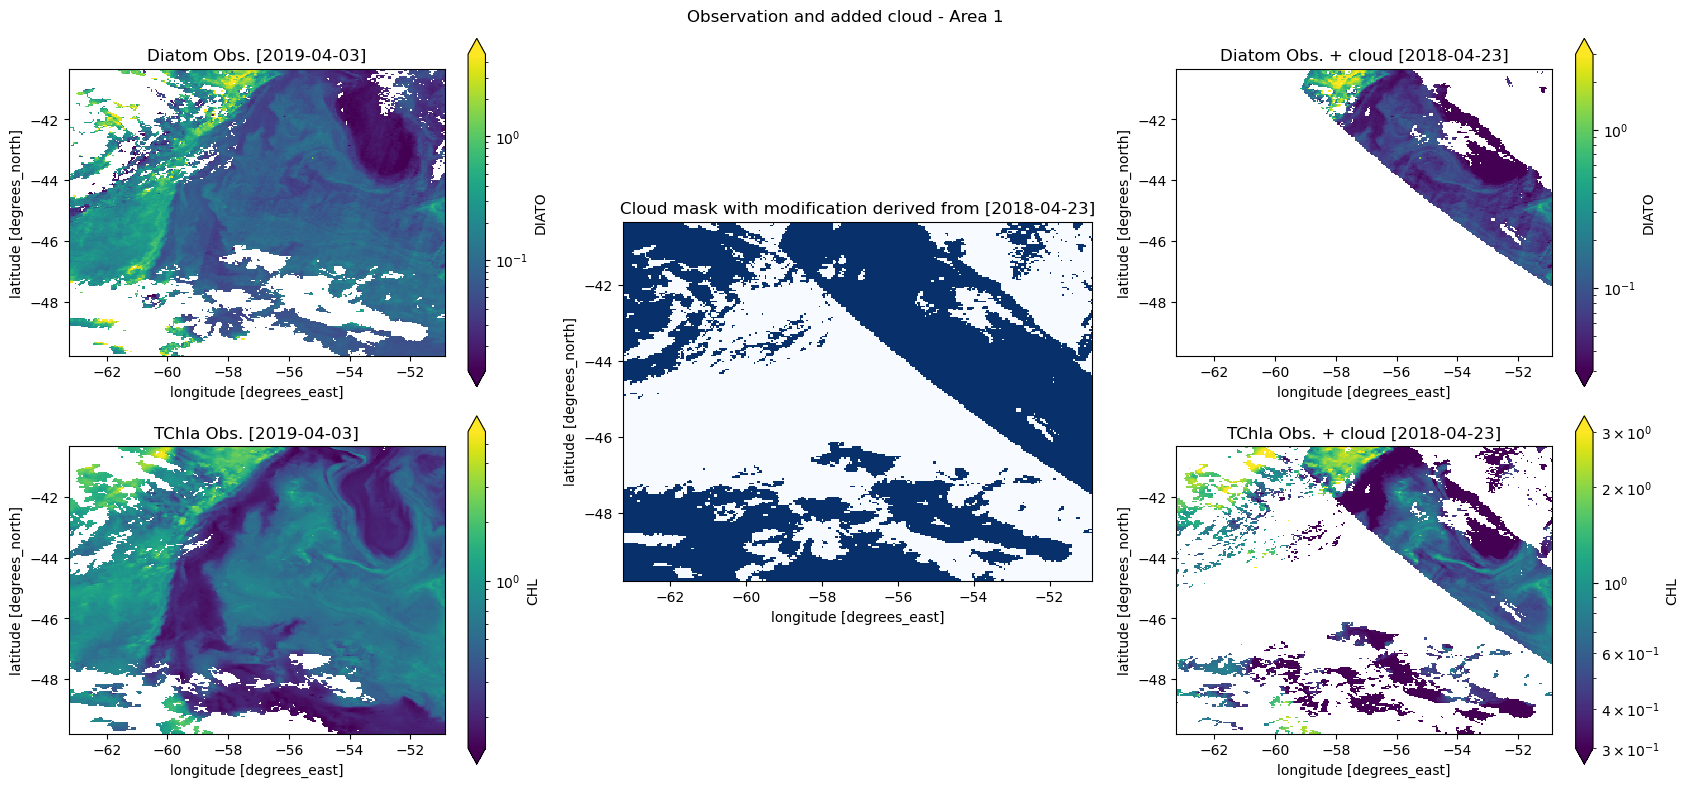

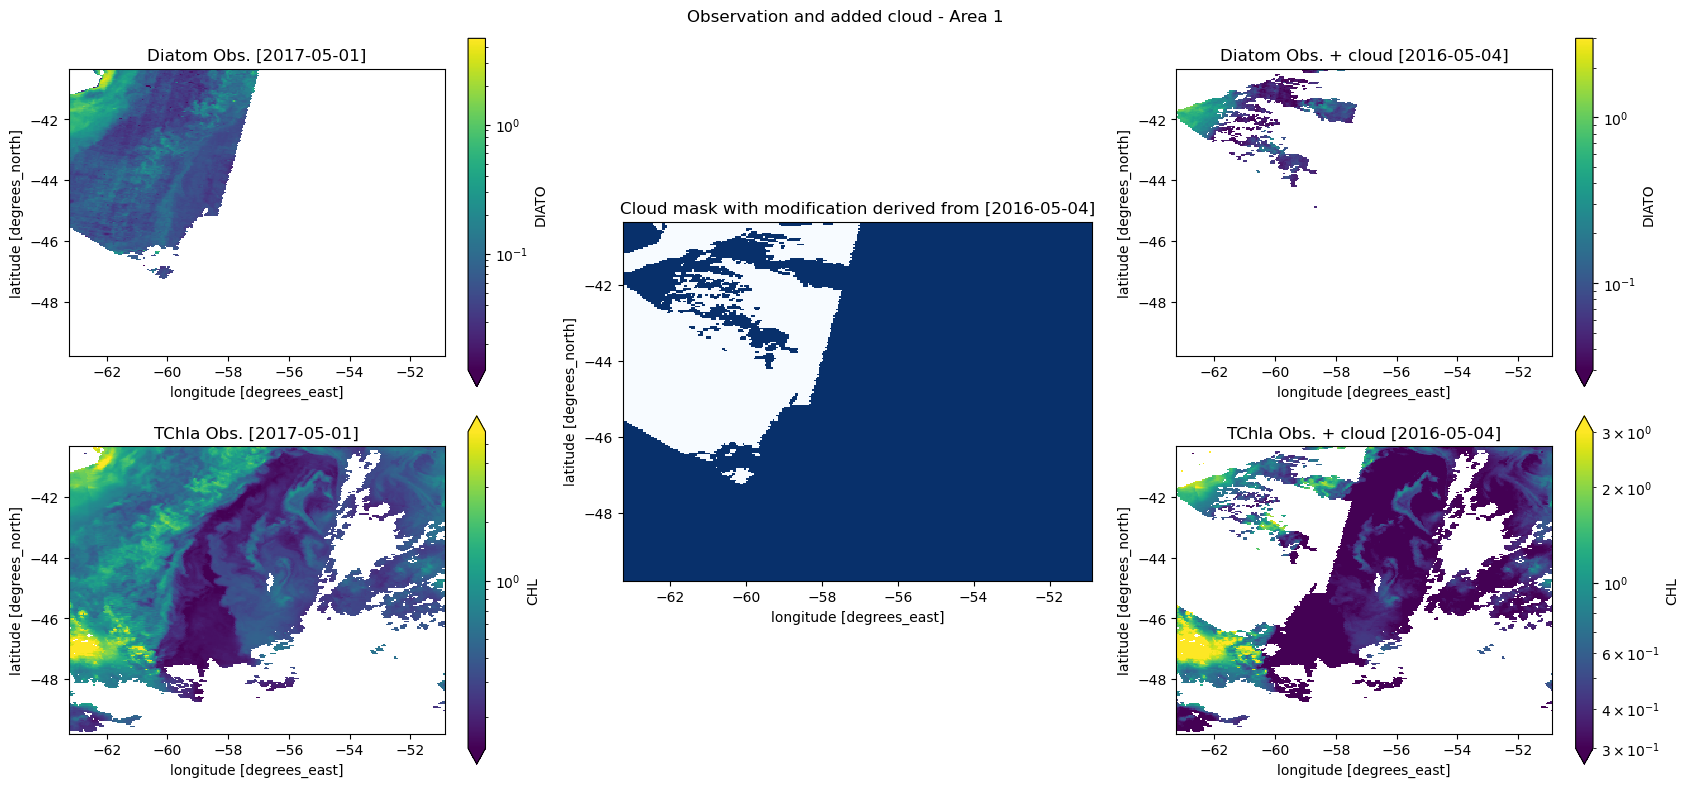

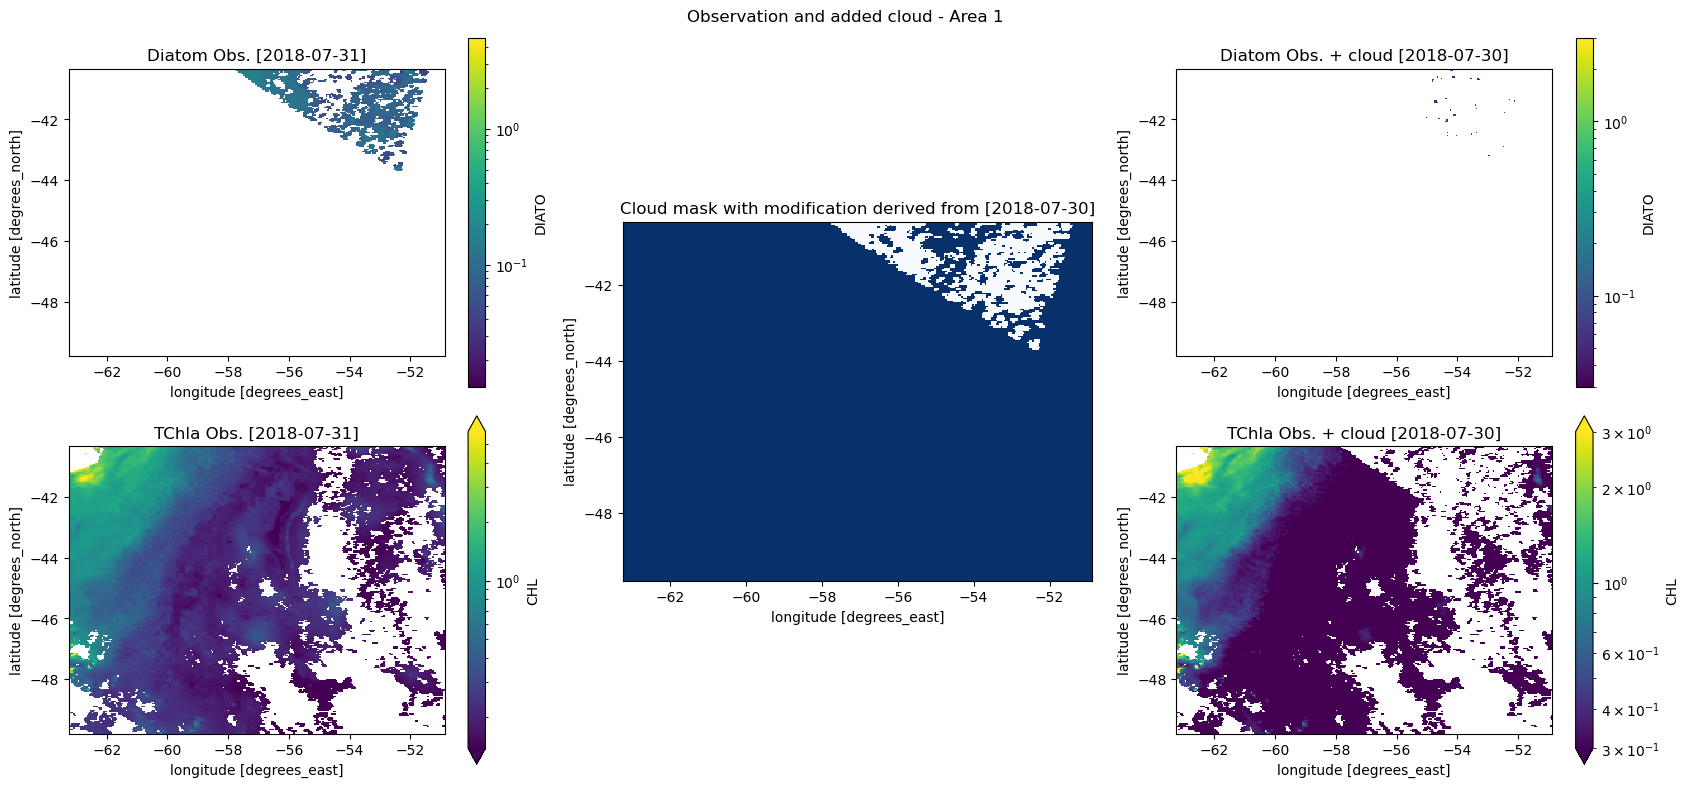

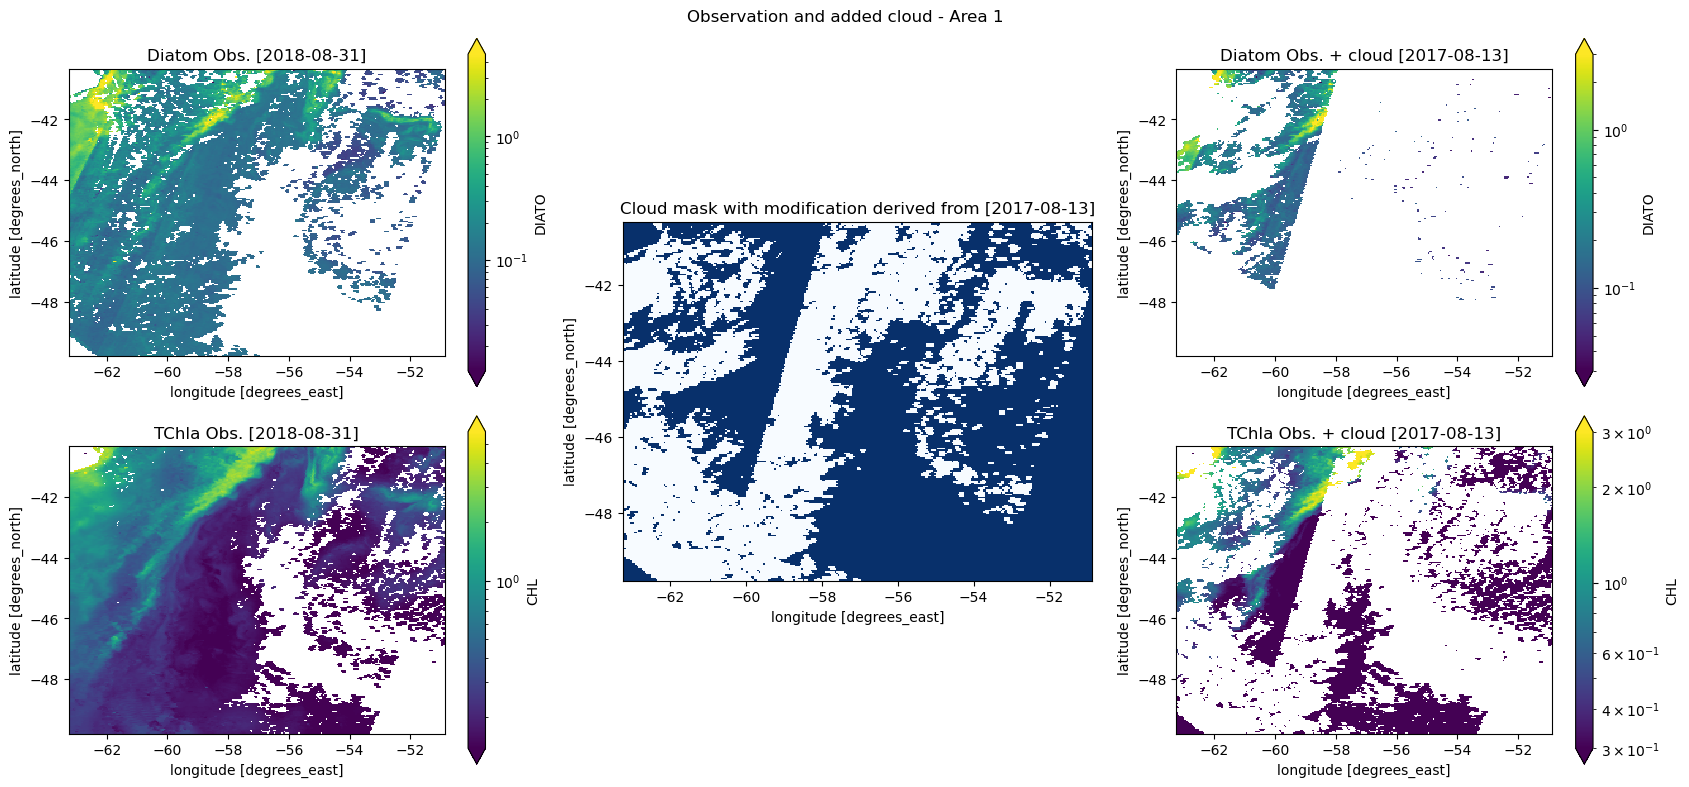

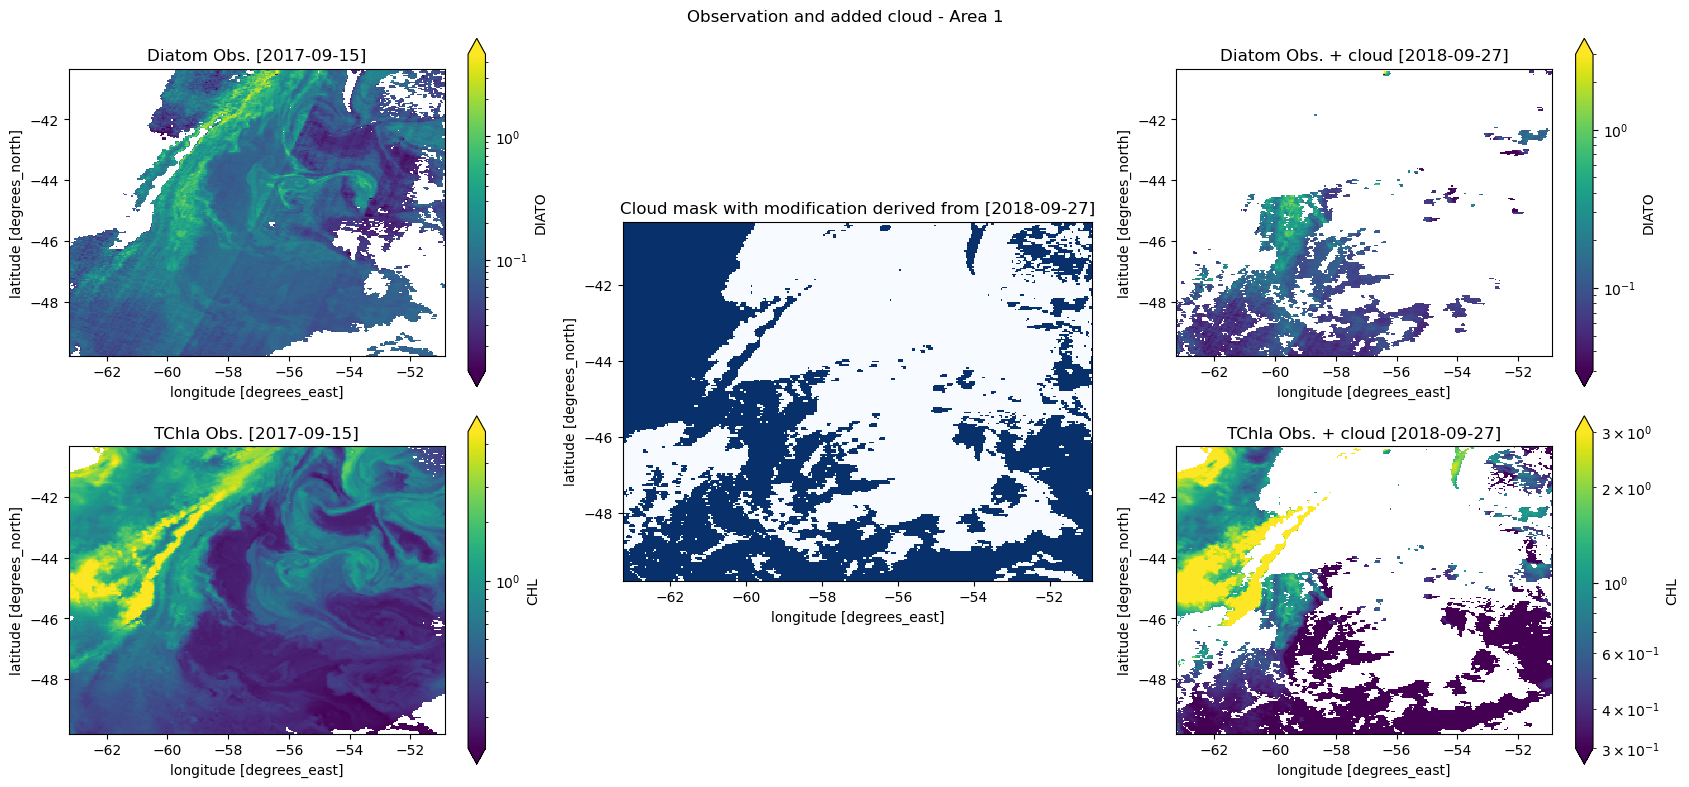

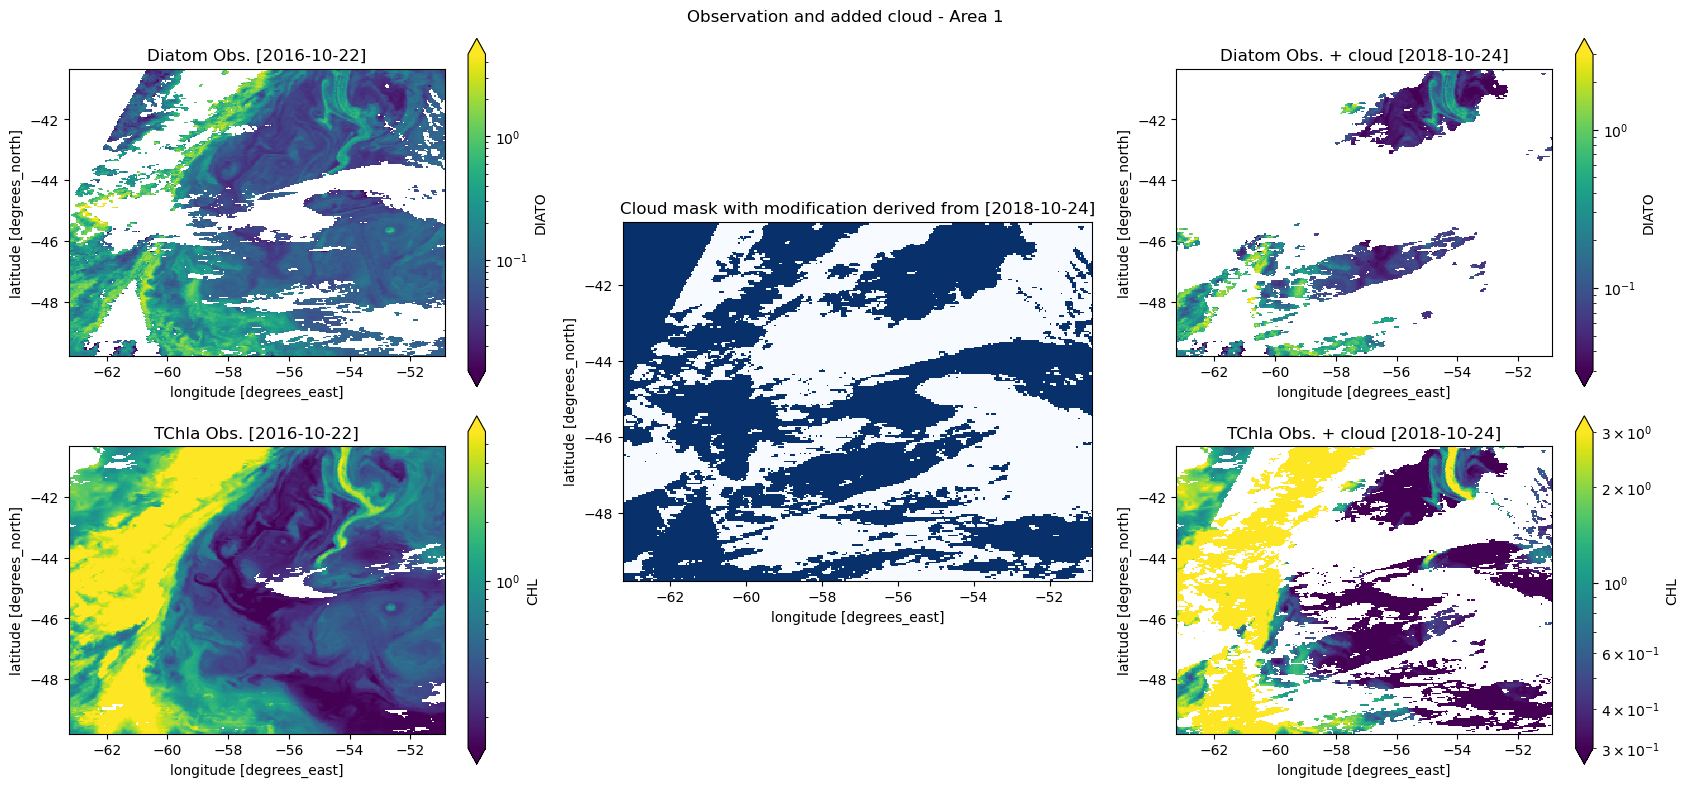

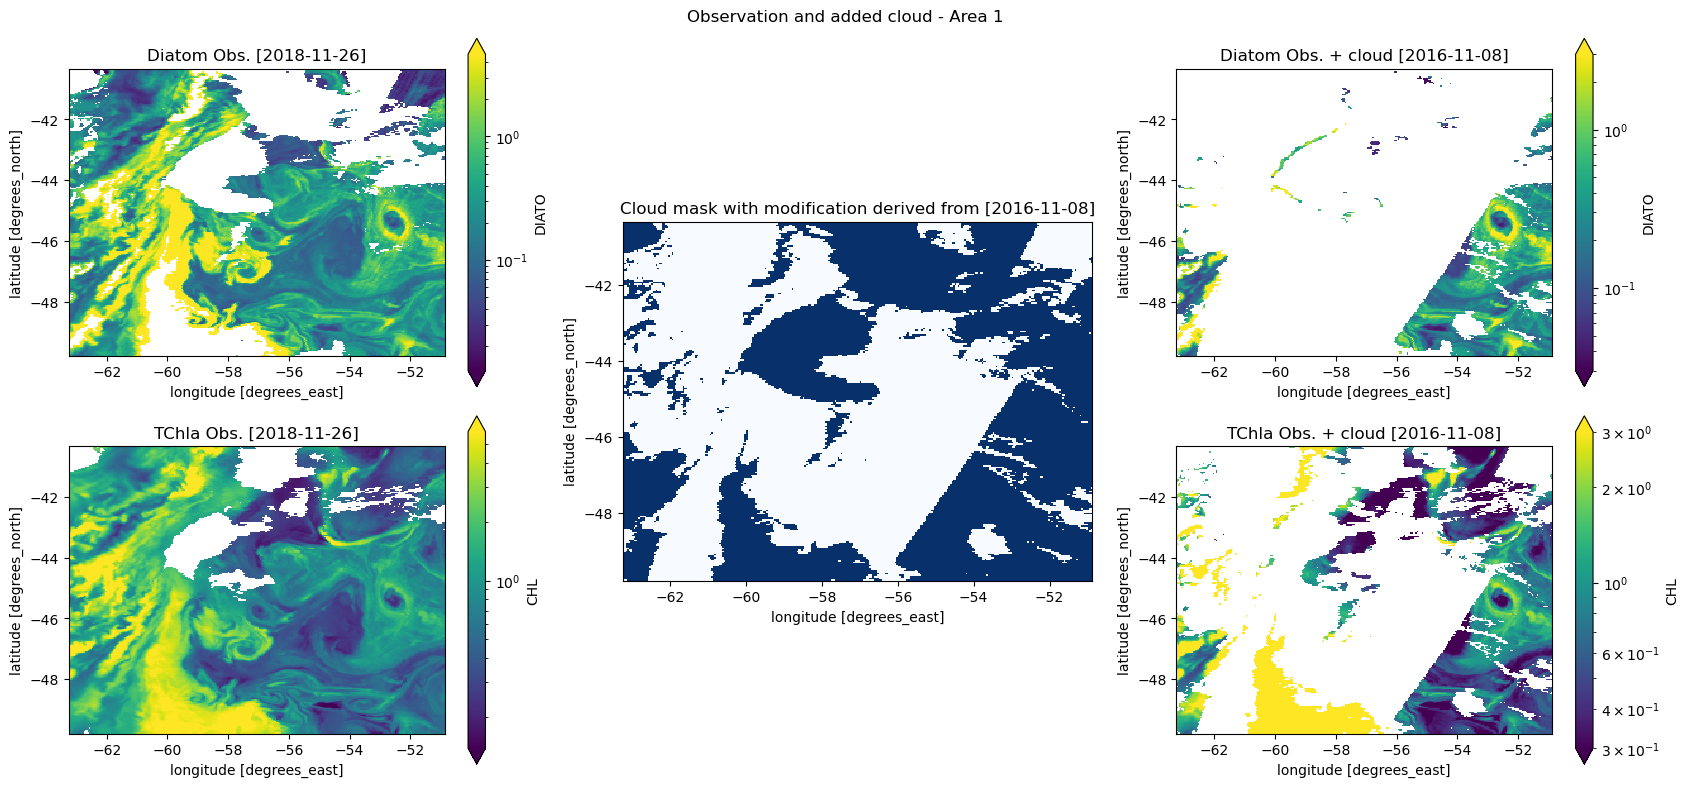

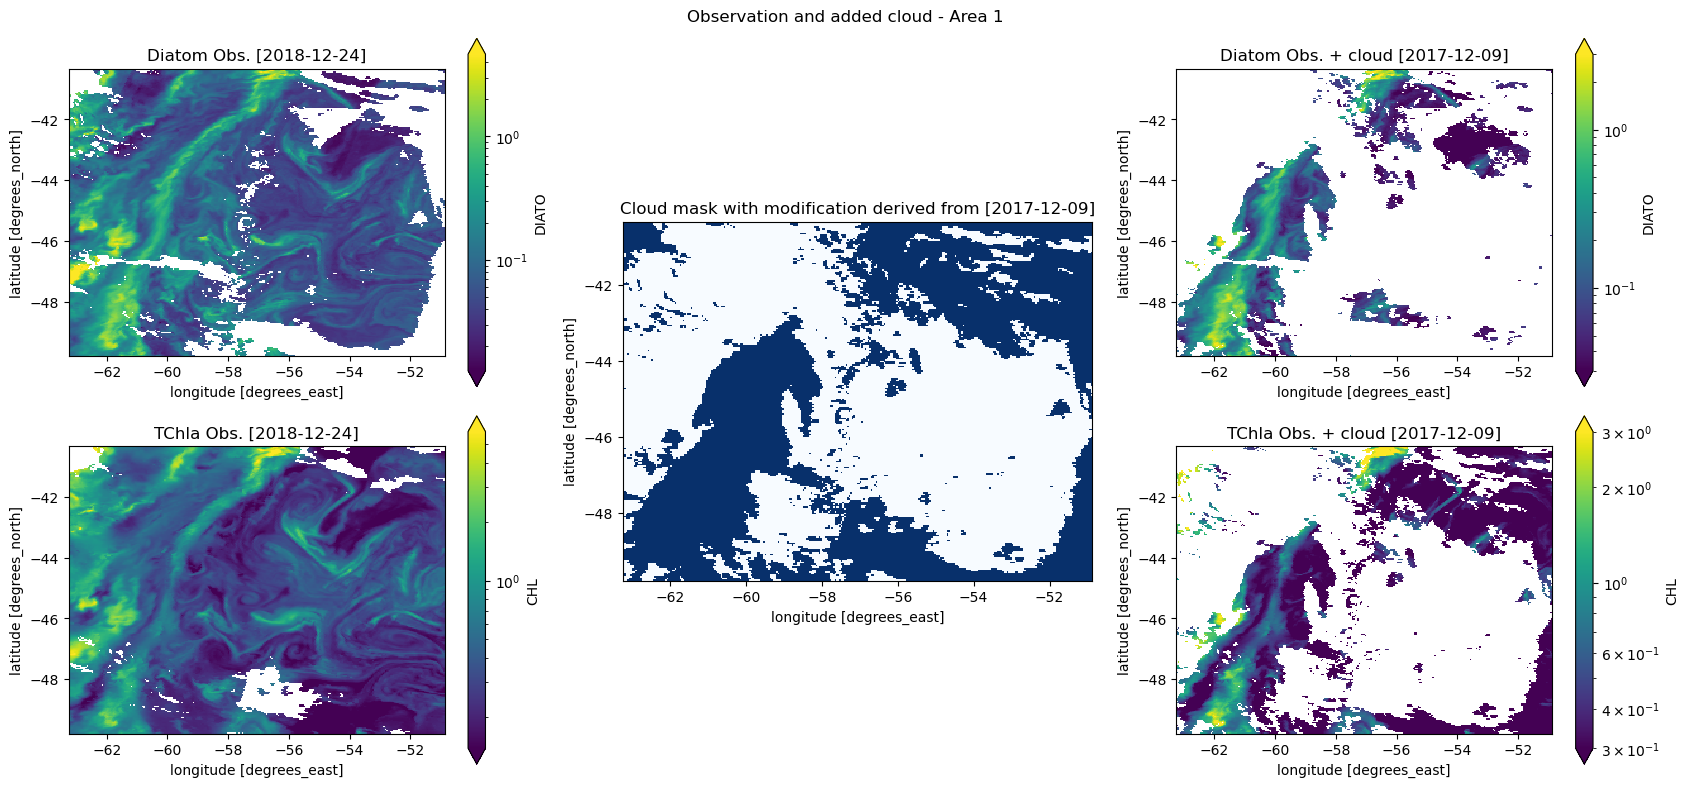

In [8]:
dev_nums = []
dev_percs = []
train_nums = []
train_percs = []

# for idx in range(1,11): ## For all the regions
for idx in [1]: ## Trial for one region
    print('Region', idx)
    
    ## Read the region dataset
    ds = xr.open_dataset(os.path.join(params['output_dir'],str(idx),'ds_pft.nc')).compute()
    
    ## remove the dates with less than 2 percentage data availability
    ds = remove_missing_dates(perc=2, ds = ds, params = params)
    print(f'number of dates region {idx}:',ds.time.size)
    
    # ---------------------------------------------------------------------------------
    ## DEV: Creating the development (validation) dataset and separating test dataset
    ds_dev, cloud_time_dev, clouded_time_dev, cloud_mask_dev, cloud_mask_chl_dev, ds_cloudindex_dev = Addcloud_monthly(
        ds.drop(['sst','sst_uncertainty']),
        params=params,
        cv_number_monthly=1,
        threshold=40,
        keep_expedition_dates = True,
    )
    
    ## Reattach the sst dataset
    ds_dev['sst'] = ds.sst.astype('float32')
    ds_dev['sst_uncertainty'] = ds.sst_uncertainty.astype('float32')
    
    ## Report
    ### Create the report on the number of test points
    dev_num = (ds.count() - ds_dev.count())[params['PFT']].to_array(dim='PFT', name=idx).to_dataframe()
    dev_nums.append(dev_num)
    ### Create the report on the percentage of the test points
    dev_perc = ((1 - (ds_dev.count()/ds.count()))*100)[params['PFT']].to_array(dim='PFT', name=idx).to_dataframe()
    dev_percs.append(dev_perc)
    
    # Fill NaN values for DINEOF reconstruction
    ds_dev_filled = NaN_fill(ds_dev, fill_value=-999)
    
    # ---------------------------------------------------------------------------------
    ## Train: Creating the training dataset and separating development dataset
    ds_train, cloud_time_train, clouded_time_train, cloud_mask_train, cloud_mask_chl_train, ds_cloudindex_train = Addcloud_monthly(
        ds_dev.drop(['sst','sst_uncertainty']), 
        params=params,
        cv_number_monthly=1,
        threshold=10,
        keep_expedition_dates = True,
    )
    
    ## Reattach the sst dataset
    ds_train['sst'] = ds.sst.astype('float32')
    ds_train['sst_uncertainty'] = ds.sst_uncertainty.astype('float32')
    
    ## Report
    ### Create the report on the number of development points
    train_num = (ds_dev.count() - ds_train.count())[params['PFT']].to_array(dim='PFT', name=idx).to_dataframe()
    train_nums.append(train_num)
    ### Create the report on the percentage of the development points
    train_perc = ((1 - (ds_train.count()/ds_dev.count()))*100)[params['PFT']].to_array(dim='PFT', name=idx).to_dataframe()
    train_percs.append(train_perc)

    # ---------------------------------------------------------------------------------
#     ## Save development datasets
#     pd.DataFrame(
#         {'cloud_date':cloud_time_dev, 'clouded_date':clouded_time_dev}
#                 ).to_csv(os.path.join(output_dir,str(idx),'cloud_date_dev.csv'), index=False)

#     ds_dev.to_netcdf(os.path.join(output_dir,str(idx),'ds_pft_dev.nc'))
#     ds_dev_filled.to_netcdf(os.path.join(output_dir,str(idx),'ds_pft_dev_filled.nc'))
#     cloud_mask_dev.to_netcdf(os.path.join(output_dir,str(idx),'cloud_mask_dev.nc'))
#     cloud_mask_chl_dev.to_netcdf(os.path.join(output_dir,str(idx),'cloud_mask_chl_dev.nc'))
#     ds_cloudindex_dev.to_netcdf(os.path.join(output_dir,str(idx),'cloud_index_dev.nc'))
#     dev_num.to_csv(os.path.join(output_dir,str(idx),'dev_num.csv'))
#     dev_perc.to_csv(os.path.join(output_dir,str(idx),'dev_perc.csv'))
    
#     # ---------------------------------------------------------------------------------
#     ## Save Training datasets
#     pd.DataFrame(
#         {'cloud_date':cloud_time_train, 'clouded_date':clouded_time_train}
#                 ).to_csv(os.path.join(output_dir,str(idx),'cloud_date_train.csv'), index=False)
    
#     ds_train.to_netcdf(os.path.join(output_dir,str(idx),'ds_pft_train.nc'))
#     cloud_mask_train.to_netcdf(os.path.join(output_dir,str(idx),'cloud_mask_train.nc'))
#     cloud_mask_chl_train.to_netcdf(os.path.join(output_dir,str(idx),'cloud_mask_chl_train.nc'))
#     ds_cloudindex_train.to_netcdf(os.path.join(output_dir,str(idx),'cloud_index_train.nc'))
#     train_num.to_csv(os.path.join(output_dir,str(idx),'train_num.csv'))
#     train_perc.to_csv(os.path.join(output_dir,str(idx),'train_perc.csv'))
    
#     # ---------------------------------------------------------------------------------
#     # Plot
    cloud_plot(idx, ds, ds_dev, cloud_mask_dev, clouded_time_dev, dataset_extension = 'dev', params=params)
    # cloud_plot(idx, ds, ds_train, cloud_mask_train,clouded_time_train, dataset_extension = 'train', params=params)
#     # ---------------------------------------------------------------------------------

## Save the reports

# dev_nums = pd.concat(dev_nums,axis=1)
# dev_percs = pd.concat(dev_percs,axis=1)
# train_nums = pd.concat(train_nums,axis=1)
# train_percs= pd.concat(train_percs,axis=1)

# dev_nums.to_csv(os.path.join(output_dir,'dev_nums.csv'))
# dev_percs.to_csv(os.path.join(output_dir,'dev_percs.csv'))
# train_nums.to_csv(os.path.join(output_dir,'train_nums.csv'))
# train_percs.to_csv(os.path.join(output_dir,'train_percs.csv'))